In [61]:
import pandas as pd
import numpy as np
import re

# библиотеки для кодирования данных
import category_encoders as ce
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

# библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')

from sklearn.feature_selection import chi2 # хи-квадрат
from sklearn.feature_selection import f_classif # anova
from sklearn.feature_selection import SelectKBest # для отбора признаков

from sklearn.model_selection import train_test_split # инструмент для разбивки данных
 
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\polub\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### 0. Подготовка

Первоначальная версия датасета содержит 17 полей со следующей информацией:

hotel_address — адрес отеля;

review_date — дата, когда рецензент разместил соответствующий отзыв;

average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;

hotel_name — название отеля;

reviewer_nationality — страна рецензента;

negative_review — отрицательный отзыв, который рецензент дал отелю;

review_total_negative_word_counts — общее количество слов в отрицательном отзыв;

positive_review — положительный отзыв, который рецензент дал отелю;

review_total_positive_word_counts — общее количество слов в положительном отзыве.

reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;

total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;

total_number_of_reviews — общее количество действительных отзывов об отеле;

tags — теги, которые рецензент дал отелю;

days_since_review — количество дней между датой проверки и датой очистки;

additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число 
указывает, сколько там действительных оценок без проверки.

lat — географическая широта отеля;

lng — географическая долгота отеля.

In [62]:
hotels = pd.read_csv('data/hotels.csv')
hotels.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


In [63]:
# Ответы на задание 2.1-2.4
display(hotels.info())
display('Пропуски значений обнаружены в столбцах "lat" и "lng"')
display(f'Столбцы с числовым форматом: {list(hotels.select_dtypes(include=["int", "float"]).columns)}')
display('Стобцы со строковым форматом: "hotel_address", "hotel_name", "reviewer_nationality", "negative_review", "positive_review", "tags", "day_since_review"')
display('Стобец, содержащий дату: "review_date"')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

None

'Пропуски значений обнаружены в столбцах "lat" и "lng"'

"Столбцы с числовым форматом: ['additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'reviewer_score', 'lat', 'lng']"

'Стобцы со строковым форматом: "hotel_address", "hotel_name", "reviewer_nationality", "negative_review", "positive_review", "tags", "day_since_review"'

'Стобец, содержащий дату: "review_date"'

In [64]:
# Ответ на задание 4.2
display(f"Число отелей в базе данных: {hotels['hotel_name'].nunique()}")

'Число отелей в базе данных: 1492'

In [65]:
# Изменение формата признака с датой отзыва
hotels['review_date'] = pd.to_datetime(hotels['review_date'], format='%m/%d/%Y')

In [66]:
# Ответ на задание 4.3
display(f"Самая старый отзыв: {hotels['review_date'].min()}")
display(f"Самая свежий отзыв: {hotels['review_date'].max()}")


'Самая старый отзыв: 2015-08-04 00:00:00'

'Самая свежий отзыв: 2017-08-03 00:00:00'

In [67]:
# Ответы на задание 4.4-4.6
# Определим уникальное количество тегов в наборе данных
def re_func(num_tags):
    """Функция, которая принимает теги отелей и возвращает список для каждой записи

    Args:
        num_tags (list): список тегов для отеля

    Returns:
        lits: список тегов для записи
    """
    found = re.findall("'[^\'](.+?)[^\']'", num_tags)
    return found


# Новый признак признак 'tags_n'
hotels['tags_n'] = hotels['tags'].apply(re_func)
df = hotels.explode('tags_n') 

display(f"Число уникальных тегов: {df['tags_n'].nunique()}")
display(df['tags_n'].value_counts(normalize=True).head(10)*100) # 10 наиболее популярных тегов

'Число уникальных тегов: 2368'

Leisure trip                      17.741957
Submitted from a mobile device    13.056584
Couple                            10.704930
Stayed 1 night                     8.224678
Stayed 2 nights                    5.672518
Solo traveler                      4.595982
Stayed 3 nights                    4.073500
Business trip                      3.507113
Group                              2.777221
Family with young children         2.593235
Name: tags_n, dtype: float64

### 1. Анализ и очистка данных

Как показали результаты анализа данных пропуски значений встречаются в признаках "lat" и "lng". Проведем анализ распределения координат отелей.

In [68]:
# Определение пропущенных значений в данных
null_mask = hotels.isnull().mean() * 100
null_cols = null_mask[null_mask>0]

# Отображение распределения значений для признаков с пропусками
cols = null_cols.index
display(cols)

Index(['lat', 'lng'], dtype='object')

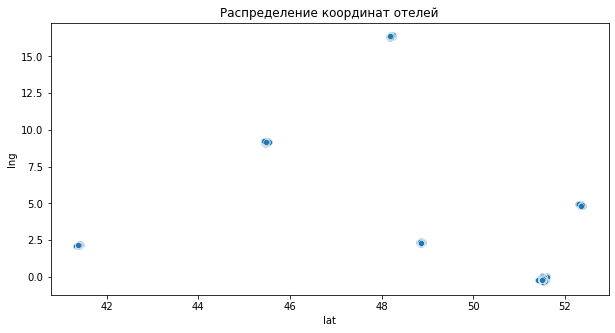

In [69]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=hotels, x='lat', y='lng')
plt.title('Распределение координат отелей');

In [70]:
# Определение записей содержаших пропуски
lat_mask = hotels['lat'].isnull()
lng_mask = hotels['lng'].isnull()

In [71]:
null_addresses = list(set(hotels[lat_mask]['hotel_address']))
null_city = []

for x in null_addresses:
    null_city.append(x.split(' ')[-2])

display(set(null_city))
display(f'Количество уникальных значений городов, для которых обнаружены пропуски: {len(set(null_city))}')

{'Barcelona', 'Paris', 'Vienna'}

'Количество уникальных значений городов, для которых обнаружены пропуски: 3'

По результатам анализа построенного распределения координат отелей, можно сделать вывод, что все отели распределенв между шестью географическими единицами. В качестве значения для заполнения пропусков можно использовать координаты начала улицы, на которой расположен отель. Количество уникальных адресов, для которых имеются пропуски, составляет 17 шт.


In [72]:
# Координаты центров городов для заполнения пропусков
center_coordinates = {'Vienna': [48.2167, 16.3733],
             'Barcelona': [41.3888, 2.15899],
             'Paris': [48.5112, 2.2055]}

In [73]:
hotels['hotel_country'] = hotels['hotel_address'].apply(lambda x: x.split(' ')[-2]+' '+x.split(' ')[-1] if 
                                                        x.split(' ')[-1] == 'Kingdom' else x.split(' ')[-1])

hotels['hotel_city'] = hotels['hotel_address'].apply(lambda x: 'London' if x.split(' ')[-1] == 'Kingdom' else x.split(' ')[-2])

# Удаление обработанного признака
hotels.drop('hotel_address', axis=1, inplace=True)

In [74]:
hotels.loc[(lat_mask & (hotels['hotel_city'] == 'Vienna')), 'lat'] = center_coordinates['Vienna'][0]
hotels.loc[(lng_mask & (hotels['hotel_city'] == 'Vienna')), 'lng'] = center_coordinates['Vienna'][1]
hotels.loc[(lat_mask & (hotels['hotel_city'] == 'Barcelona')), 'lat'] = center_coordinates['Barcelona'][0]
hotels.loc[(lng_mask & (hotels['hotel_city'] == 'Barcelona')), 'lng'] = center_coordinates['Barcelona'][1]
hotels.loc[(lat_mask & (hotels['hotel_city'] == 'Paris')), 'lat'] = center_coordinates['Paris'][0]
hotels.loc[(lng_mask & (hotels['hotel_city'] == 'Paris')), 'lng'] = center_coordinates['Paris'][1]

In [75]:
# Проверка отсутствия пропущенных значений в данных
# Определение пропущенных значений в данных
null_mask = hotels.isnull().mean() * 100
null_cols = null_mask[null_mask>0]

# Отображение распределения значений для признаков с пропусками
cols = null_cols.index
display(cols)

Index([], dtype='object')

<AxesSubplot:>

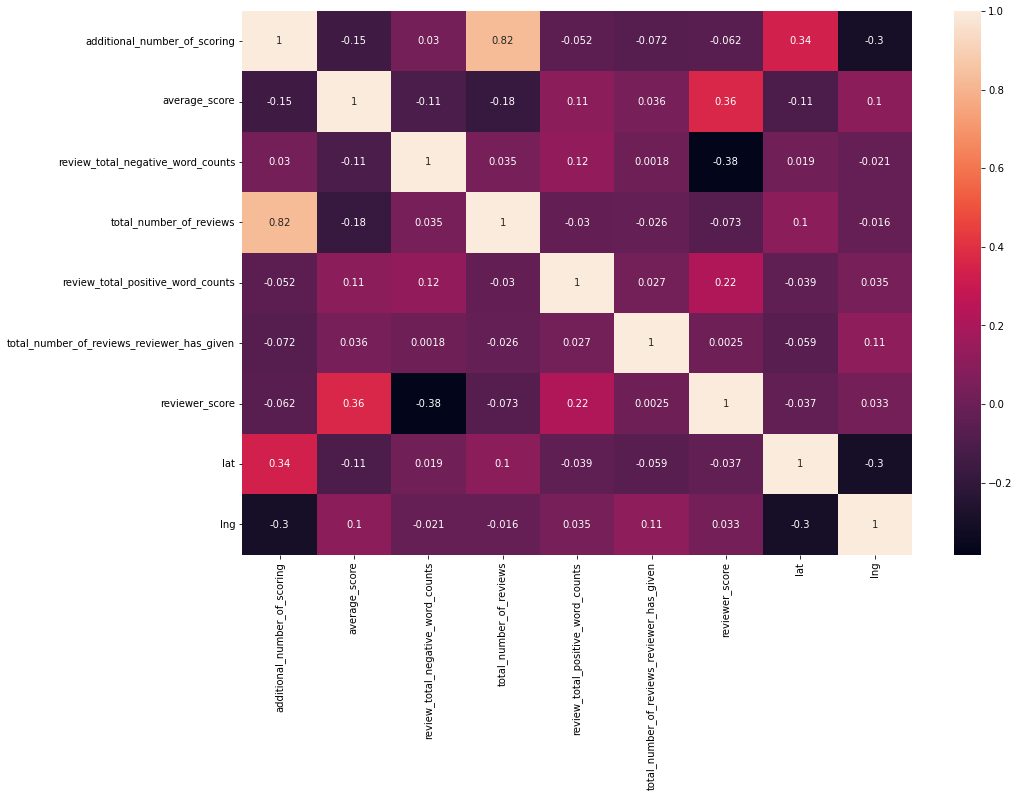

In [76]:
# Проверак признаков на мультиколлинеарность
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(hotels.corr(), annot=True)

In [77]:
# Убираем признаки с сильной корреляцией
hotels.drop('additional_number_of_scoring', axis=1, inplace=True)

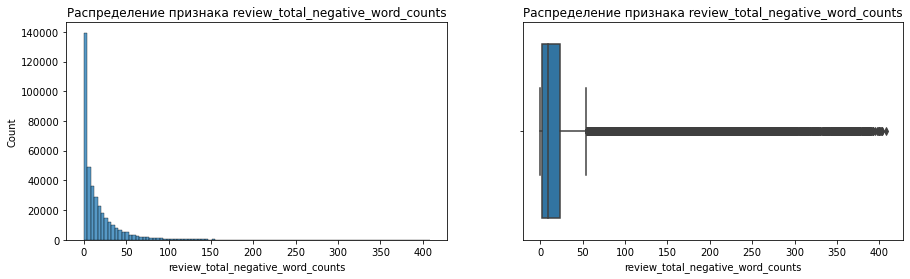

In [78]:
# Построение гистораммы и корбчатой диаграммы для признака review_total_negative_word_counts
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=hotels, x='review_total_negative_word_counts', ax=axes[0], bins=100)
histplot.set_title('Распределение признака review_total_negative_word_counts')
boxplot = sns.boxplot(data=hotels, x='review_total_negative_word_counts', ax=axes[1])
boxplot.set_title('Распределение признака review_total_negative_word_counts');

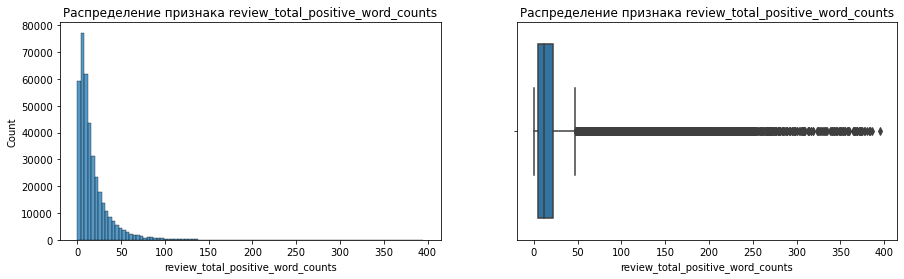

In [79]:
# Построение гистораммы и корбчатой диаграммы для признака review_total_positive_word_counts
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=hotels, x='review_total_positive_word_counts', ax=axes[0], bins=100)
histplot.set_title('Распределение признака review_total_positive_word_counts')
boxplot = sns.boxplot(data=hotels, x='review_total_positive_word_counts', ax=axes[1])
boxplot.set_title('Распределение признака review_total_positive_word_counts');

Анализ распределения признаков review_total_negative_word_counts и review_total_positive_word_counts показывает, что оба признака распределены ненормально. В целях повышения точности модели необходимо будет нормализовать данные признаки. Кроме того имеются множественные выбросы значений, что говорит о необходимости нормализацим методом RobustScaler.

In [80]:
# Подготовка даннных для построения зависимости
grouped_data_neg = hotels.groupby(
    by='reviewer_score',
    as_index=False
)['review_total_negative_word_counts'].median()

# Построение зависимости признака reviewer_score от признака review_total_negative_word_counts
px.histogram(
    grouped_data_neg, 
    x='reviewer_score', 
    y='review_total_negative_word_counts',
    title='Распределение медианного количества слов негативных отзывов по признаку reviewer_score',
    nbins=20
)

In [81]:
# Подготовка даннных для построения зависимости
grouped_data_pos = hotels.groupby(
    by='reviewer_score',
    as_index=False
)['review_total_positive_word_counts'].median()

# Построение зависимости признака reviewer_score от признака review_total_positive_word_counts
px.histogram(
    grouped_data_pos, 
    x='reviewer_score', 
    y='review_total_positive_word_counts',
    title='Распределение медианного количества слов позитивных отзывов по признаку reviewer_score',
    nbins=20
)

По результатам анализа распределения медианного количества слов позитивных и отрицательных отзывов по признаку reviewer_score можно сделать вывод о наличии зависимости количиства позитивных и негативных слов и признака reviewer_score. Можно предположить, что данные признаки будет оказывать значительное влияния на точность модели.

### 2. Генерация и преобразование признаков

#### 2.1 Признак tags

In [82]:
# Создадим признак, описывающий тип поездки (type_trip)
def get_type_trip(tags:list):
    """Функция для определения типа поездки из тега

    Args:
        tags (list): Список тегов

    Returns:
        str: Тип поездки
    """
    for tag in tags:
        if tag == 'Business trip':
            return 'Business trip'
        elif tag == 'Leisure trip':
            return 'Leisure trip'
    return 'Other'


hotels['type_trip'] = hotels['tags_n'].apply(get_type_trip)
 

In [83]:
# Создадим признак, описывающий количество проведенных ночей (nights_count)
def get_nights(tags:list):
    """Функция для извлечения количества ночей из тэга

    Args:
        tags (list): Список тэгов

    Returns:
        str: Количество ночей
    """
    for tag in tags:
        if tag == 'Stayed 1 night':
            return 'Stayed 1 night'
        elif tag == 'Stayed 2 nights':
            return 'Stayed 2 nights'
    return 'More than 2 nights'


hotels['nights_count'] = hotels['tags_n'].apply(get_nights)

In [84]:
# Создадим признак, описывающий тип путешественников
def get_travaler_type(tags:list):
    for tag in tags:
        if tag == 'Solo traveler':
            return 'Solo traveler'
        elif tag == 'Couple':
            return 'Couple'
        elif tag == 'Group':
            return 'Group'
    return 'Other'

hotels['traveler_type'] = hotels['tags_n'].apply(get_travaler_type)

#### 2.2 Признак reviewer_nationality

In [85]:
display(f"Количество уникальных национальностей: {hotels['reviewer_nationality'].nunique()}")

'Количество уникальных национальностей: 225'

In [86]:
# Отберем 10 наиболее часто встречающихся национальностей
nat_list = list(hotels['reviewer_nationality'].value_counts().head(10).index)

for x in nat_list:
    x.replace(' ','')

hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(lambda x: x if x in nat_list else 'Other')

#### 2.3 Признак review_date

In [87]:
# Создание новых признаков на основе даты отзыва
hotels['review_month'] = hotels['review_date'].dt.month.astype(int)
hotels['review_weekday'] = hotels['review_date'].dt.dayofweek.astype(int)
hotels['days_since_review'] = ((hotels['review_date'].max() - hotels['review_date'])/np.timedelta64(1,'D')).astype(int)

#### 2.4 Признаки negative_review и positive_review

In [88]:
hotels['negative_review'].value_counts().head(10)

No Negative    95907
 Nothing       10737
 Nothing        3154
 nothing        1660
 N A             802
 None            737
                 606
 N a             384
 Breakfast       296
 Small room      283
Name: negative_review, dtype: int64

Как видно из результатов вывода наиболее часто встречаемых негативных отзывов в данных имеются значения "No Negative" и "Nothing" и т.д., которые в контексте данного проекта не являются негативными. Необходимо заменить данные значения, чтобы не искажались результаты обучения модели.

In [89]:
hotels['positive_review'].value_counts().head(10)

No Positive        26885
 Location           6833
 Everything         1697
 location           1251
 Nothing             931
 The location        830
 Great location      809
 Good location       690
 Location            663
 Breakfast           455
Name: positive_review, dtype: int64

Как видно из результатов вывода наиболее часто встречаемых положительных отзывов в данных имеются значения "No Positive" и "Nothing" и т.д., которые в контексте данного проекта не являются негативными. Необходимо заменить данные значения, чтобы не искажались результаты обучения модели.

In [90]:
replace = {    
    'positive_review': ['no positive','nothing'],
    'negative_review': [
        'nothing really','no negative','nothing','n a','none','nothing at all','nothing to dislike',
        'everything was perfect','na','can t think of anything','nil','everything was great','absolutely nothing',
        'nothing to complain about','no','nothing not to like','nothing all good','no complaints','i liked everything'
        ,'liked everything'
    ]
    
}

In [91]:
for key in replace:
    for value in replace[key]:
        hotels.loc[hotels[key].str.strip().str.lower()==value,key] = ''
        
hotels['review_total_positive_word_counts'] = hotels['positive_review'].apply(lambda s: len(s.strip().split(' ')))
hotels['review_total_negative_word_counts'] = hotels['negative_review'].apply(lambda s: len(s.strip().split(' ')))

hotels['review_diff'] = hotels['positive_review'].str.len() - hotels['negative_review'].str.len()

In [92]:
# Воспользуемся библиотекой обработки текста для определения контекста отзыва
sent_analyzer = SentimentIntensityAnalyzer()

hotels['rev_neg'] = hotels['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x))
hotels['rev_pos'] = hotels['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x))

#hotels.loc[:, 'n_compound'] = list(hotels['rev_neg'].apply(lambda x: x['compound']).values)
#hotels.loc[:, 'p_compound'] = list(hotels['rev_pos'].apply(lambda x: x['compound']).values)

hotels.loc[:,['n_neg', 'n_neu', 'n_pos', 'n_compound']] = list(hotels['rev_neg'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)
hotels.loc[:,['p_neg', 'p_neu', 'p_pos', 'p_compound']] = list(hotels['rev_pos'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)

### 3. Кодирование признаков

In [93]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 34 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   review_date                                 386803 non-null  datetime64[ns]
 1   average_score                               386803 non-null  float64       
 2   hotel_name                                  386803 non-null  object        
 3   reviewer_nationality                        386803 non-null  object        
 4   negative_review                             386803 non-null  object        
 5   review_total_negative_word_counts           386803 non-null  int64         
 6   total_number_of_reviews                     386803 non-null  int64         
 7   positive_review                             386803 non-null  object        
 8   review_total_positive_word_counts           386803 non-null  int64        

In [94]:
# Проанализируем количество уникальных значений по столбца (за исключением tags_n и сформированных по результатам анализа контекста отзыва)
for col in hotels.columns.tolist()[:24]:
    if col == 'tags_n':
        pass
    else:
        display(f'Количество уникальных значение признака - {col}: {hotels[col].nunique()}')

'Количество уникальных значение признака - review_date: 731'

'Количество уникальных значение признака - average_score: 34'

'Количество уникальных значение признака - hotel_name: 1492'

'Количество уникальных значение признака - reviewer_nationality: 11'

'Количество уникальных значение признака - negative_review: 248712'

'Количество уникальных значение признака - review_total_negative_word_counts: 400'

'Количество уникальных значение признака - total_number_of_reviews: 1142'

'Количество уникальных значение признака - positive_review: 311731'

'Количество уникальных значение признака - review_total_positive_word_counts: 354'

'Количество уникальных значение признака - total_number_of_reviews_reviewer_has_given: 194'

'Количество уникальных значение признака - reviewer_score: 37'

'Количество уникальных значение признака - tags: 47135'

'Количество уникальных значение признака - days_since_review: 731'

'Количество уникальных значение признака - lat: 1475'

'Количество уникальных значение признака - lng: 1475'

'Количество уникальных значение признака - hotel_country: 6'

'Количество уникальных значение признака - hotel_city: 6'

'Количество уникальных значение признака - type_trip: 3'

'Количество уникальных значение признака - nights_count: 3'

'Количество уникальных значение признака - traveler_type: 4'

'Количество уникальных значение признака - review_month: 12'

'Количество уникальных значение признака - review_weekday: 7'

'Количество уникальных значение признака - review_diff: 2871'

Принцип кодирования признаков:

- Для порядковых признаков - OrdinalEncoding
- Для номинальных признаков (если менее 15) - OneHotEncoding
- Для номинальных признаков (если более 15) - BinaryEncoding

In [95]:
# Закодируем признак reviewer_nationality
ord_encoder = ce.OrdinalEncoder()
data_bin = ord_encoder.fit_transform(hotels['reviewer_nationality'])
hotels = pd.concat([hotels, data_bin], axis=1)

In [96]:
# Закодируем признаки type_trip, traveler_type, nights_count
encoder = ce.OneHotEncoder(cols=['type_trip'])
type_bin = encoder.fit_transform(hotels['type_trip'])
hotels = pd.concat([hotels, type_bin], axis=1)

encoder = ce.OneHotEncoder(cols=['traveler_type'])
type_bin = encoder.fit_transform(hotels['traveler_type'])
hotels = pd.concat([hotels, type_bin], axis=1)

encoder = ce.OneHotEncoder(cols=['nights_count'])
type_bin = encoder.fit_transform(hotels['nights_count'])
hotels = pd.concat([hotels, type_bin], axis=1)

c:\Users\polub\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



### 4. Преобразование признаков

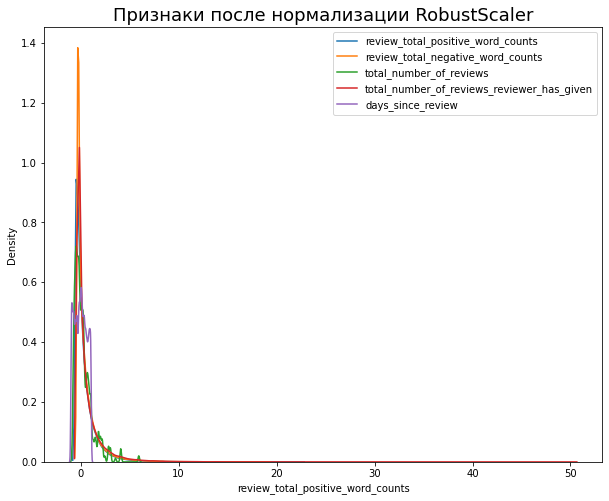

In [97]:
# Нормализация числовых признаков

cols_norm = ['review_total_positive_word_counts', 'review_total_negative_word_counts',
            'total_number_of_reviews', 'total_number_of_reviews_reviewer_has_given',
            'days_since_review'] # числовые признаки для нормализации

rs_scaler = preprocessing.RobustScaler()
hotels_norm = hotels[cols_norm].copy()

hotels_norm_rs = rs_scaler.fit_transform(hotels_norm)
hotels_norm_rs = pd.DataFrame(hotels_norm_rs, columns=cols_norm)


# Визуализация
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Признаки после нормализации RobustScaler', fontdict={'fontsize': 18})

for col in cols_norm:
    sns.kdeplot(hotels_norm_rs[col], ax=ax1)

plt.legend(cols_norm)

In [98]:
hotels.drop(cols_norm, axis=1, inplace=True)
hotels = pd.concat([hotels, hotels_norm_rs[cols_norm]], axis=1)

### 5. Отбор признаков

In [99]:
# убираем признаки которые были обработаны 
# модель на признаках с dtypes "object" и "datetime64[ns]" обучаться не будет
cols_to_drop = ['review_date', 'hotel_name', 'reviewer_nationality', 'negative_review', 'positive_review',
               'hotel_country', 'hotel_city', 'tags_n', 'type_trip', 'nights_count', 'traveler_type',
               'rev_neg', 'rev_pos', 'tags']

hotels.drop(cols_to_drop, axis = 1, inplace=True)

#object_columns = [s for s in data.columns if data[s].dtypes == 'object']
#date_columns = ['review_date']

#data.drop(object_columns, axis = 1, inplace=True)
#data.drop(date_columns, axis = 1, inplace=True)

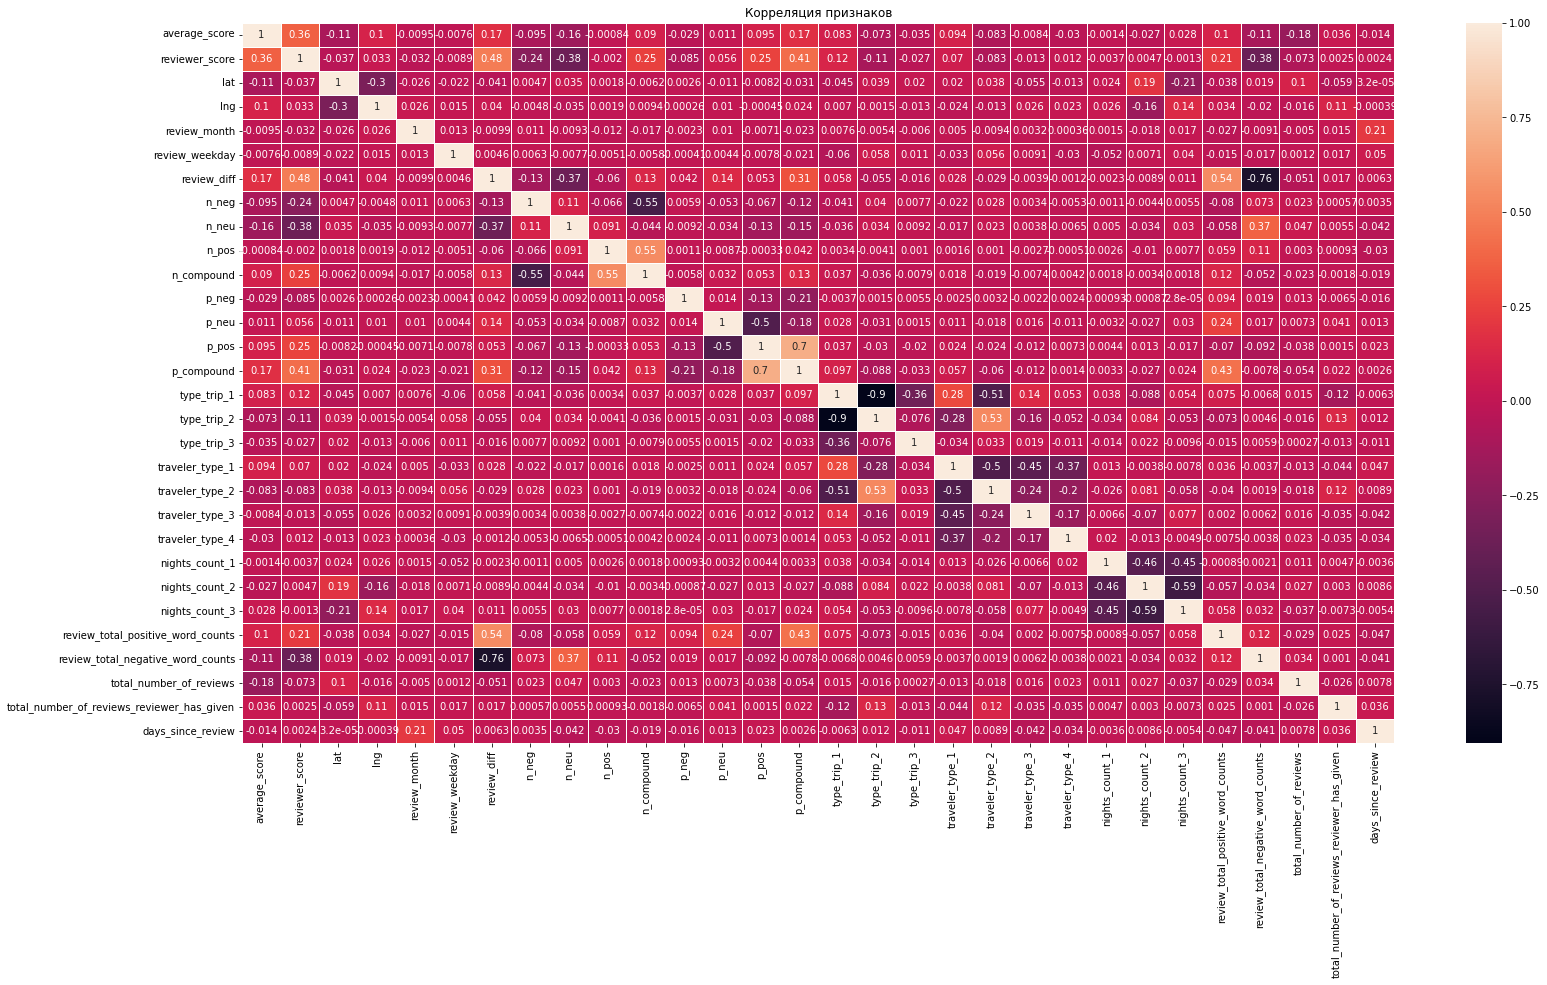

In [100]:
# Отбор признаков по условию мультиколлинеарности
fig = plt.figure(figsize=(20,10))
axes = fig.add_axes([1,1,1,1])
sns.heatmap(data=hotels.corr(), annot=True, linewidths=0.5)
axes.set_title('Корреляция признаков');

In [101]:
# Удалим мультиколлинеарные признаки
# Удаление мультиколлинеарных признаков привело к ухудшению точности модели
#cols_to_drop = ['review_total_negative_word_counts', 'type_trip_2']
#data.drop(cols_to_drop, axis=1, inplace=True)

In [102]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels['reviewer_score']

In [106]:
# Формирование списка непрервывных признаков
num_cols = ['total_number_of_reviews_reviewer_has_given', 'days_since_review', 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts',
            'review_month', 'review_weekday', 'n_compound', 'p_compound', 'review_diff'
]

# Формированике списка категориальных признаков
cat_cols = ['average_score', 'type_trip_1', 'type_trip_2', 'type_trip_3', 'nights_count_1', 'nights_count_2',
            'nights_count_3'
]

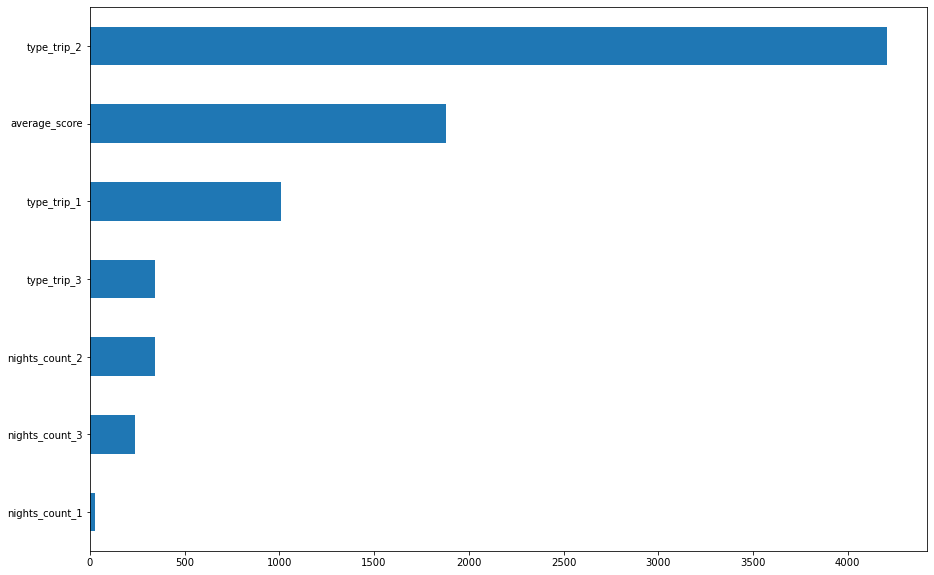

In [104]:
# Оценка значимости категориальных признаков
y = y.astype('int')

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh');

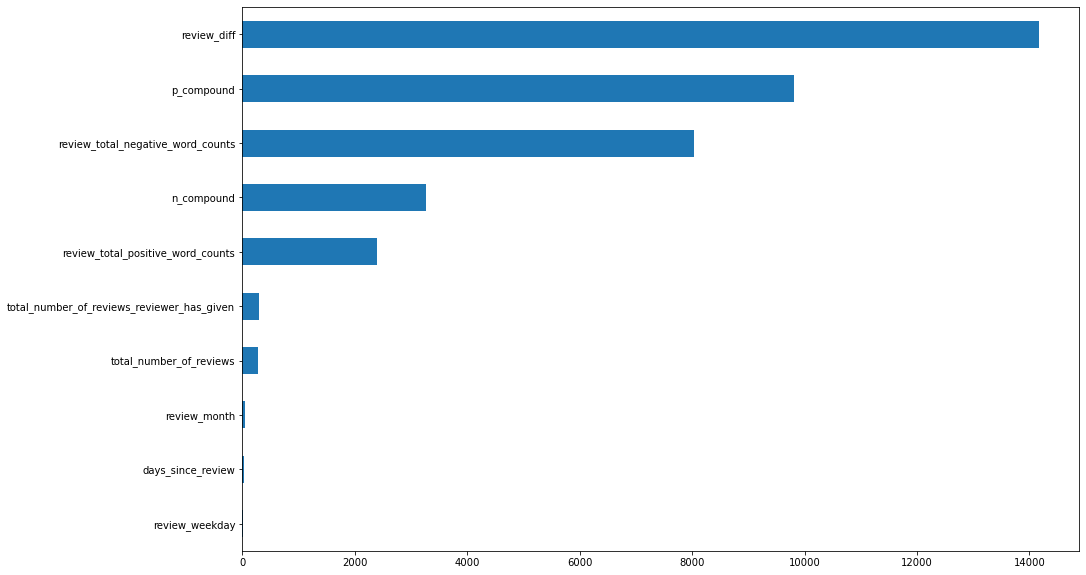

In [107]:
# Оценка значимости непрерывных признаков
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh');

### 6. Создание и обучение модели

In [108]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [109]:
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  


In [110]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.1471299246261139
